<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Align-and-annotate-reads-from-10X-single-cell-sequencing-of-influenza-infected-cells" data-toc-modified-id="Align-and-annotate-reads-from-10X-single-cell-sequencing-of-influenza-infected-cells-1">Align and annotate reads from 10X single-cell sequencing of influenza-infected cells</a></span><ul class="toc-item"><li><span><a href="#Set-up" data-toc-modified-id="Set-up-1.1">Set up</a></span><ul class="toc-item"><li><span><a href="#Modules,-programs,-directories" data-toc-modified-id="Modules,-programs,-directories-1.1.1">Modules, programs, directories</a></span></li><li><span><a href="#Samples-and-sequencing-runs" data-toc-modified-id="Samples-and-sequencing-runs-1.1.2">Samples and sequencing runs</a></span></li></ul></li><li><span><a href="#Build-the-reference-genome" data-toc-modified-id="Build-the-reference-genome-1.2">Build the reference genome</a></span></li><li><span><a href="#De-multiplex-the-deep-sequencing-reads" data-toc-modified-id="De-multiplex-the-deep-sequencing-reads-1.3">De-multiplex the deep sequencing reads</a></span></li><li><span><a href="#Align-the-reads-and-count-the-genes-per-cell" data-toc-modified-id="Align-the-reads-and-count-the-genes-per-cell-1.4">Align the reads and count the genes per cell</a></span></li><li><span><a href="#Annotate-synonymous-barcodes-on-the-influenza-reads" data-toc-modified-id="Annotate-synonymous-barcodes-on-the-influenza-reads-1.5">Annotate synonymous barcodes on the influenza reads</a></span></li><li><span><a href="#Build-merged-cell-gene-matrix-suitable-for-loading-into-Monocle" data-toc-modified-id="Build-merged-cell-gene-matrix-suitable-for-loading-into-Monocle-1.6">Build merged cell-gene matrix suitable for loading into Monocle</a></span></li></ul></li></ul></div>

# Align and annotate reads from 10X single-cell sequencing of influenza-infected cells
This notebook processes the raw sequencing data from the 10X sequencing. 

The data are from A549 (human) cells infected with influenza virus, plus some MDCK (canine) cells that are **not** infected with virus and so serve as a lysis control.

The influenza viruses are a mix of a  _wildtype_ population and a _synonymously barcoded_ A/WSN/1933 (H1N1) virus.
The synonymously barcoded viruses have synonymous mutations near the 3' end of their mRNAs in order to enable them to be distinguished from the wildtype virus, thus quantifying the rate of cellular co-infection.

Much of the the data processing is done using the 10X software [cellranger](https://support.10xgenomics.com/single-cell/software/pipelines/latest/what-is-cell-ranger).
In some cases, custom scripts are used for non-standard steps relating to handling the influenza reads.

Specifically, this notebook performs the following operations:

   1. Builds a reference genome to which reads are aligned.
   2. De-multiplexes the reads using `cellranger`.
   3. Aligns the de-multiplexed reads to the reference genome to generate the cell-gene count matrix.
   4. Annotates the synonymous barcodes on the influenza reads.
   5. Annotates the total number of influenza reads for each cell. This is iportant for the *canine* cells as the cell-gene matrix created by [cellranger](https://support.10xgenomics.com/single-cell/software/pipelines/latest/what-is-cell-ranger) for these does **not** include flu reads as they aren't in the *canine* genome.
   5. Gets all the results in a format that make them ready for downstream analysis with [Monocle](http://cole-trapnell-lab.github.io/monocle-release/). Basically this is by annotating the cells `*.tsv` file for the cell-gene matrix.

## Set up 
First some basic set up for the analysis.

### Modules, programs, directories
Import modules used in this notebook, print information about program versions, and define created directories.
The [pymodules.utils](pymodules/utils.py) module contains custom functions used for this analysis.

In [1]:
import os
import collections
import multiprocessing
import shutil

from IPython.display import Image, display
import pymodules.utils

print("Using following version of cellranger:")
!cellranger count --version

resultsdir = './results/'
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
plotsdir = os.path.join(resultsdir, './plots/')
if not os.path.isdir(plotsdir):
    os.mkdir(plotsdir)
    
maxcpus = min(15, multiprocessing.cpu_count())  

Using following version of cellranger:
/fh/fast/bloom_j/software/cellranger-2.2.0/cellranger-cs/2.2.0/bin
cellranger count (2.2.0)
Copyright (c) 2018 10x Genomics, Inc.  All rights reserved.
-------------------------------------------------------------------------------

 


### Samples and sequencing runs
We just analyze the following sample:

  - *IFN_enriched*: MACS-sorted IFN+ cells collected at 13 hours. These cells should be enriched for IFN expression.

In [2]:
samples = ['IFN_enriched']

There were several sequencing runs. 
Below we define the relevant information for each run, referring to the location of the BCL files on the Hutch cluster.

In [3]:
# sequencing runs
seqruns = ['2017-03-14', '2017-07-21'] 

# BCLs on Hutch server for each run, flow cells extracted from BCL path
bcl_dir = '/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/' 
bcl_dirs = {
        '2017-03-14':os.path.join(bcl_dir, '170314_SN367_0883_AHJLLJBCXY.bcl'),
        '2017-07-21':os.path.join(bcl_dir, '170721_SN367_0961_BHNGGKBCXY'),
        }
# flow cell is last 9 letters of directory name
flow_cells = dict([
        (sample, os.path.splitext(os.path.basename(sampledir))[0][-9 : ])
            for (sample, sampledir) in bcl_dirs.items()
        ])

# sample sheets giving lanes and indices for each run
bcl_samplesheets = {
        '2017-03-14':'''Lane, Sample,       Index
                           1, IFN_enriched, SI-GA-A3
                           2, IFN_enriched, SI-GA-A3
                           1, not_enriched, SI-GA-A2
                           2, not_enriched, SI-GA-A2
                     '''.replace(' ', ''),
        '2017-07-21':'''Lane, Sample,      Index
                           2, IFN_enriched, SI-GA-A3
                           2, not_enriched, SI-GA-A2
                     '''.replace(' ', ''),
        }

# set mask to trim extra reads from index as needed for each run
# We used the v2 reagents, and so specify the mask appropriate for that on 
# the run that was sequenced with both v1 and v2
# https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/using/bcl2fastq-direct
mask = {
        '2017-03-14':'',
        '2017-07-21':'--use-bases-mask=Y26n72,I8n6,n8,Y98'
       }

seqruns_for_sample = collections.defaultdict(set)
for seqrun in seqruns:
    for line in bcl_samplesheets[seqrun].splitlines():
        sample = line.split(',')[1].strip()
        seqruns_for_sample[sample].add(seqrun)
            
for sample in samples:
    print("Sequenced {0} in the following runs: {1}".format(sample,
            ', '.join(seqruns_for_sample[sample])))

Sequenced IFN_enriched in the following runs: 2017-03-14, 2017-07-21


## Build the reference genome
We need a non-standard reference genome.
Specifically, we expect three kinds of cells:

   1. A549 (human) cells not infected with influenza,
   
   2. A549 cells infected with the WSN strain of influenza,
   
   3. MDCK-SIAT1 (canine) cells not infected with influenza
   
We therefore use `cellranger mkref` [to build a multi-species genome]( https://support.10xgenomics.com/single-cell/software/pipelines/latest/advanced/references). 
The two genomes are:

  1. the concatenation of the human and influenza genomes, since we expect both human and viral mRNAs to be found in the same cell
  
  2. the canine genome.
  

The reference genome is built by [./scripts/mkrefgenome.bash](scripts/mkrefgenome.bash), which downloads the human and canine genomes from [ensembl](http://www.ensembl.org/index.html) and uses the flu genome in [./data/flu_sequences/](./data/flu_sequences/) (specifically, [flu-wsn.fasta](./data/flu_sequences/flu-wsn.fasta) and [flu-wsn.gtf](./data/flu_sequences/flu-wsn.gtf)), and then runs `cellrangermkref`.
We do **not** worry about including both the wildtype and synonymously barcoded influenza genomes, since the `cellranger` aligner seems sufficiently permissive that it aligns both the barcoded and non-barcoded influenza reads to the wildtype genome -- therefore we only include the wildtype influenza genome.

The resulting genome is named `humanplusflu_and_canine` to reflect the fact that it consists of the concatenated human + influenza genomes, and the canine genome.

In [4]:
celltypes = ['humanplusflu', 'canine']

refgenome = './humanplusflu_and_canine/'
if not os.path.isdir(refgenome):
    print("Creating reference genome...")
    log = !./scripts/mkrefgenome.bash || rm -r {refgenome}
    assert os.path.isdir(refgenome), "Failed to make reference genome"
    print("Reference genome is in {0}".format(refgenome))
else:
    print("Using existing reference genome")

Creating reference genome...
Reference genome is in ./humanplusflu_and_canine/


## De-multiplex the deep sequencing reads
Next, we de-multiplex the deep sequencing reads from the BCL output of the Illumina sequencer to FASTQ files using `cellranger mkfastq` as [described here](https://support.10xgenomics.com/single-cell/software/pipelines/latest/using/mkfastq).

De-multiplexed reads for 2017-03-14 already in ./results/demultiplexed_reads/2017-03-14


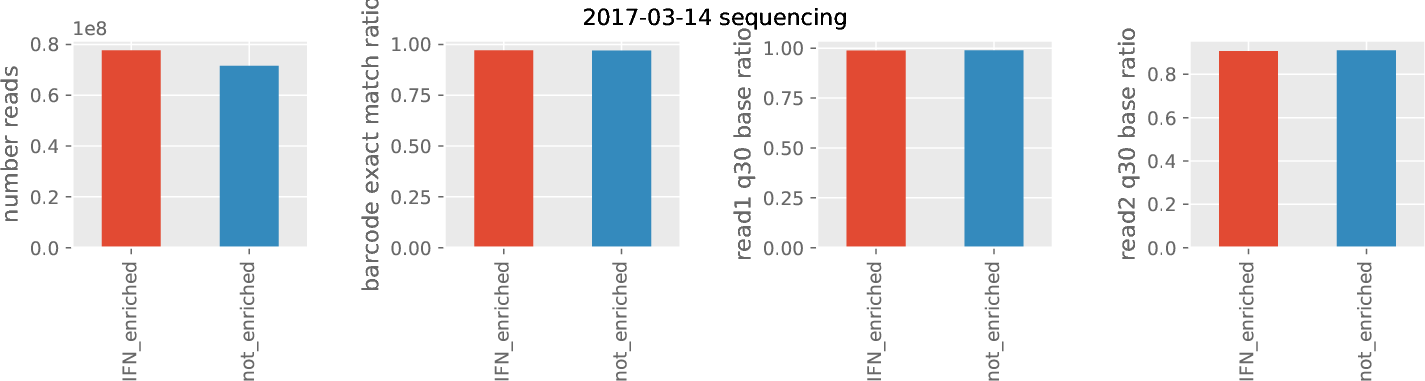

De-multiplexed reads for 2017-07-21 already in ./results/demultiplexed_reads/2017-07-21


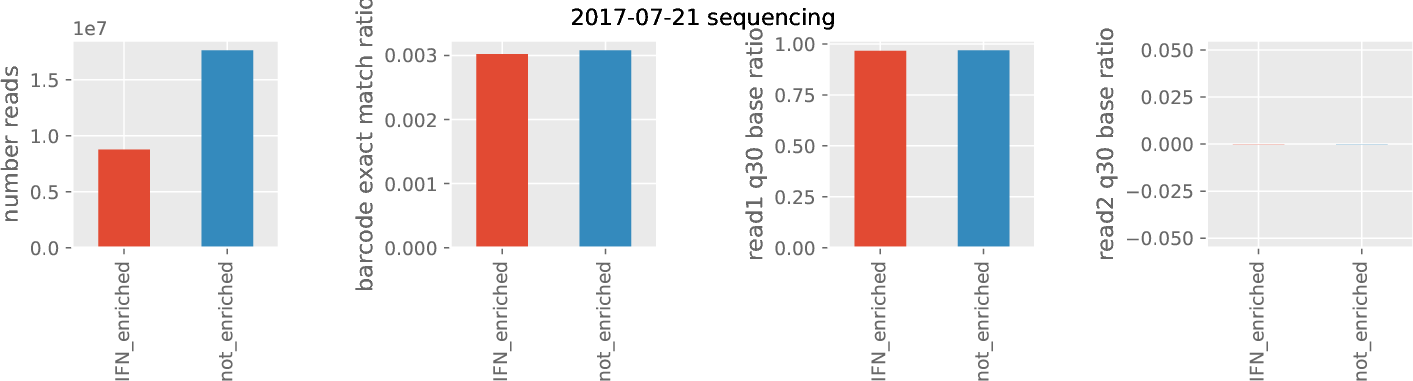

All de-multiplexing is complete.


In [5]:
demuxdir = os.path.join(resultsdir, 'demultiplexed_reads/')
if not os.path.isdir(demuxdir):
    os.mkdir(demuxdir)
    
for seqrun in seqruns:
    outdir = os.path.join(demuxdir, seqrun)
    qcplot = os.path.join(plotsdir, '{0}_demux.pdf'.format(seqrun))
    
    if os.path.isdir(outdir):
        print("De-multiplexed reads for {0} already in {1}".format(seqrun, outdir))
    else:
        print("De-multiplexing {0} into {1}...".format(seqrun, outdir))
        samplesheet = os.path.join(demuxdir, '{0}_samplesheet.csv'.format(seqrun))
        with open(samplesheet, 'w') as f:
            f.write(bcl_samplesheets[seqrun])
        flowcell = flow_cells[seqrun]
        mro = '__{0}.mro'.format(flowcell)
        
        # run cellranger, move output files to outdir, delete unneeded output
        log = !(cellranger mkfastq --qc --run={bcl_dirs[seqrun]} --output-dir={outdir} \
                --csv={samplesheet} --project=fastq {mask[seqrun]} \
                && mv {mro} {outdir} && mv {flowcell} {outdir}/pipestance) || \
                (rm -r {outdir} && rm {mro} rm -r {flowcell})
                
    qc = os.path.join(outdir, 'pipestance/outs/qc_summary.json')
    if not os.path.isfile(qcplot):
        pymodules.utils.demuxSummary(qc, qcplot, '{0} sequencing'.format(seqrun))
    pymodules.utils.showPDF(qcplot)
    
print("All de-multiplexing is complete.")

The plots above summarize the de-multiplexing.
The only thing that looks off is that that the _barcode exact match ratio_ is very low for the _2017-07-21_ sequencing run.
However, I have looked at this extensively, and the actual data seem fine---the called barcodes match to the same ones in the _2017-03-14_ sequencing. 
So we'll proceed anyway.

## Align the reads and count the genes per cell
We use `cellranger count` to align the reads to the reference genome and classify the reads into cells.
Because our samples are spread over multiple flow cells, we have to use MRO files to tell `cellranger` to combine these [as described here](https://support.10xgenomics.com/single-cell/software/pipelines/latest/advanced/multi-flowcell).

We also copy the resulting cell-gene counts to a separate subdirectory so that they are easy to find and modify subsequently below.

Finally, we print the links to the `cellranger` websummary pages, and make some plots summarizing the results.

Alignments and counts already created for IFN_enriched in ./results/./alignments_and_counts/IFN_enriched
The cellranger web summary for this IFN_enriched is in ./results/./plots/cellranger_web_summary_IFN_enriched.html

Here is a plot summarizing the results:


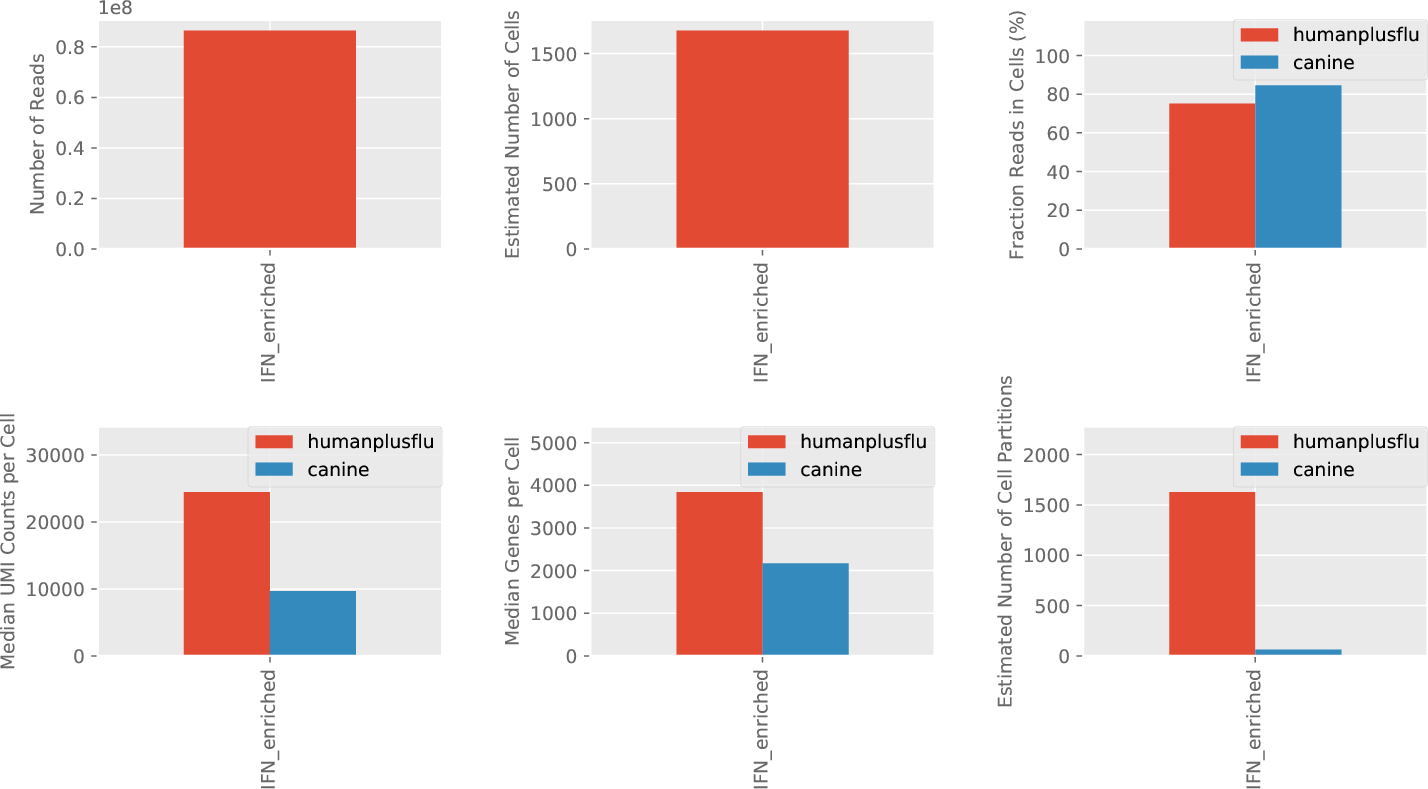

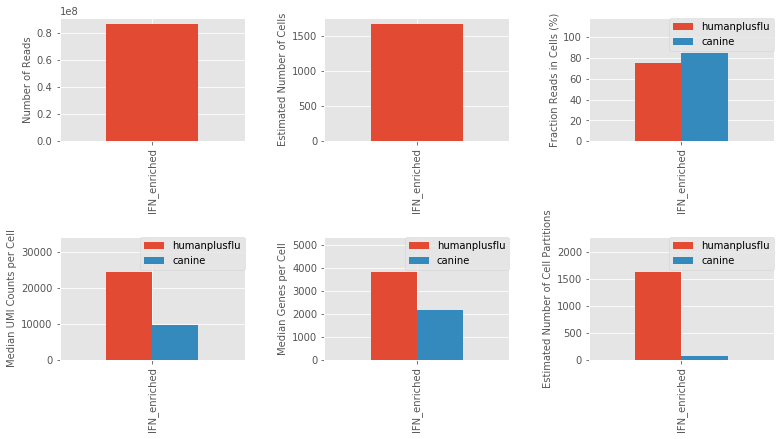

In [6]:
aligndir = os.path.join(resultsdir, './alignments_and_counts/')
if not os.path.isdir(aligndir):
    os.mkdir(aligndir)
    
countsdir = os.path.join(resultsdir, './cellgenecounts/')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
      
alignmetrics = []
cellgene_d = collections.defaultdict(lambda: collections.defaultdict(dict))
counts = {} # directory with cellgenecounts for each sample
bamfiles = {} # BAM files for each sample, used to annotate synonymous barcodes

for sample in samples:
    
    # process the reads for the sample
    sample_demuxdirs = [os.path.abspath(os.path.join(demuxdir, seqrun, 'fastq')) 
            for seqrun in seqruns_for_sample[sample]]
    outdir = os.path.join(aligndir, sample)
    websummary = os.path.join(plotsdir, 'cellranger_web_summary_{0}.html'.format(sample))
    
    if os.path.isdir(outdir):
        print("Alignments and counts already created for {0} in {1}".format(sample, outdir))
    else:
        print("Making alignments and counts for {0}...".format(sample))
        log = !cellranger count \
                          --id={sample} \
                          --transcriptome={refgenome} \
                          --sample={sample} \
                          --fastqs={','.join(sample_demuxdirs)} \
                          --localcores={maxcpus} \
                          --nosecondary 
        !mv {sample} {outdir}
        assert os.path.isdir(outdir)
        print("Alignments and counts for {0} now in {1}".format(sample, outdir))
        
    if not os.path.isfile(websummary):
        shutil.copy(os.path.join(outdir, 'outs', 'web_summary.html'), websummary)
    assert os.path.isfile(websummary), "Can't find {0}".format(websummary)
    print("The cellranger web summary for this {0} is in {1}".format(sample, websummary))
    
    bamfiles[sample] = os.path.join(outdir, 'outs/possorted_genome_bam.bam')
    counts[sample] = os.path.join(countsdir, sample)
    if not os.path.isdir(counts[sample]):
        os.mkdir(counts[sample])
    for f in ['matrix.mtx', 'genes.tsv', 'barcodes.tsv']:
        for celltype in celltypes:
            fullf = os.path.join(counts[sample], '{0}_{1}'.format(celltype, f))
            cellgene_d[celltype][os.path.splitext(f)[0]][sample] = fullf
            if not os.path.isfile(fullf):
                shutil.copy(os.path.join(outdir, 'outs', 
                        'filtered_gene_bc_matrices', celltype, f), fullf)
    alignmetrics.append(os.path.join(outdir, 'outs', 'metrics_summary.csv'))

print("\nHere is a plot summarizing the results:")
countsummaryplot = os.path.join(plotsdir, 'align_and_count_summary.pdf')

pymodules.utils.countSummary(samples, alignmetrics, countsummaryplot,
        celltypes=['humanplusflu', 'canine'])
pymodules.utils.showPDF(countsummaryplot)

These summaries show that the samples has a bit over 1,500 cells, which is as expected.

We have many more human than canine cells which is as expected, since we only put canine cells in at a low fraction.
We also have more reads per cell for the human cells, which may be because they have more RNA content?

Overall, these summaries appear to indicate that everything worked well.

## Annotate synonymous barcodes on the influenza reads
The cells were infected with a mix of wildtype virus and virus carrying "barcodes" (two synonymous mutations) so near each end of the vRNA. 
One of these barcodes should often be in the 3' region of the mRNA read by the 10X sequencing.
The sequences of the wildtype and _double-syn_ barcoded viruses are in:
  - [./data/flu_sequences/flu-wsn.fasta](./data/flu_sequences/flu-wsn.fasta)
  - [./data/flu_sequences/flu-wsn-double-syn.fasta](./data/flu_sequences/flu-wsn-double-syn.fasta)

In [7]:
flu_genes = './data/flu_sequences/flu-wsn.fasta'
flu_doublesyn_genes = './data/flu_sequences/flu-wsn-double-syn.fasta'

The `cellranger` alignments were just done to the wildtype flu genes.
The aligner is permissive enough that this appears to align all reads just fine, but we want to annotate reads with which viral variant they are from.
We do that with the custom Python script [./scripts/annotate_synbarcodes.py](./scripts/annotate_synbarcodes.py).

Note that this script only annotated reads based on the synonymous barcodes at the 3' end of the viral mRNAs, since the ones at the 5' end are not generally read by the 10X Illumina sequencing.

Importantly, these annotations are added to the `*.tsv` file with the cell annotations for each matrix.

Synonymous barcodes already annotated for IFN_enriched humanplusflu
Synonymous barcodes already annotated for IFN_enriched canine

**********************
Plots on viral umistats
For the humanplusflu cells:


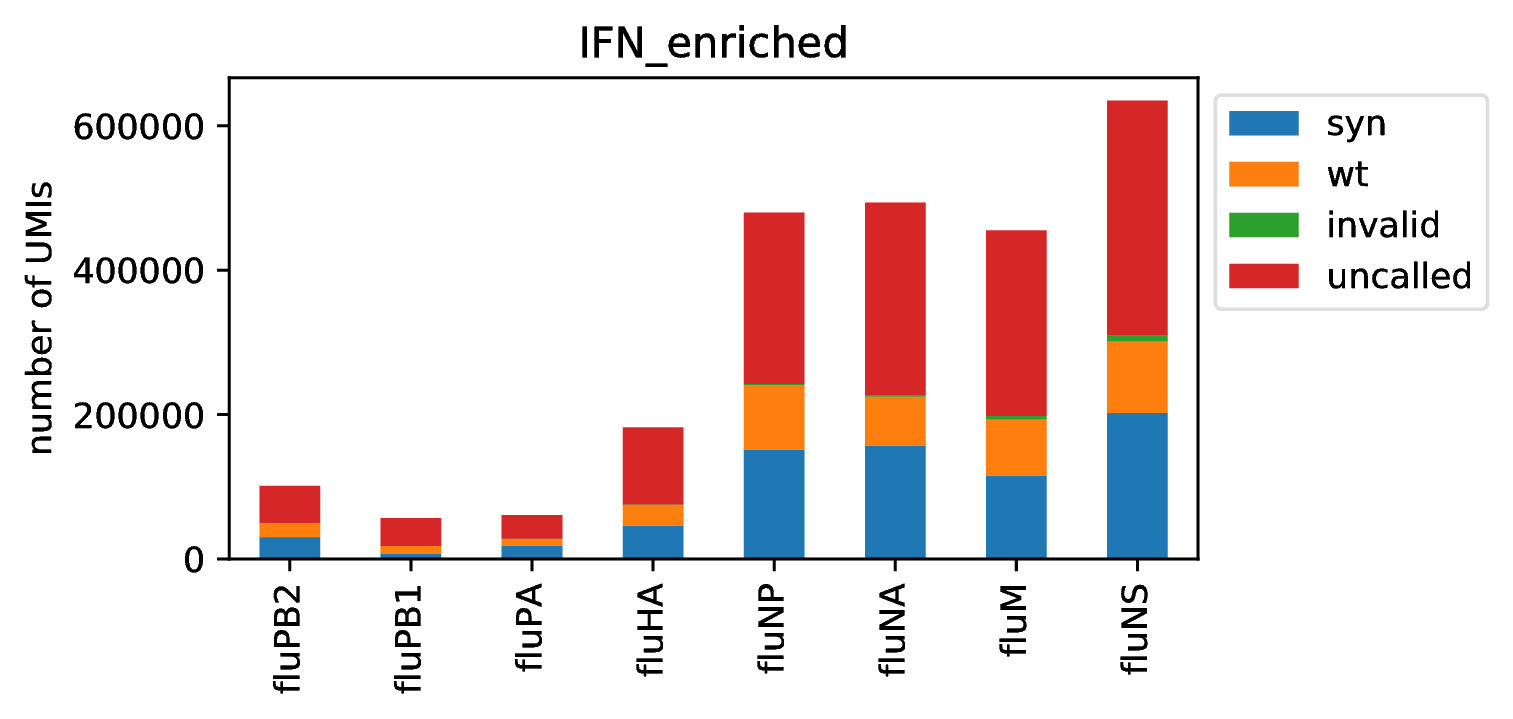

For the canine cells:


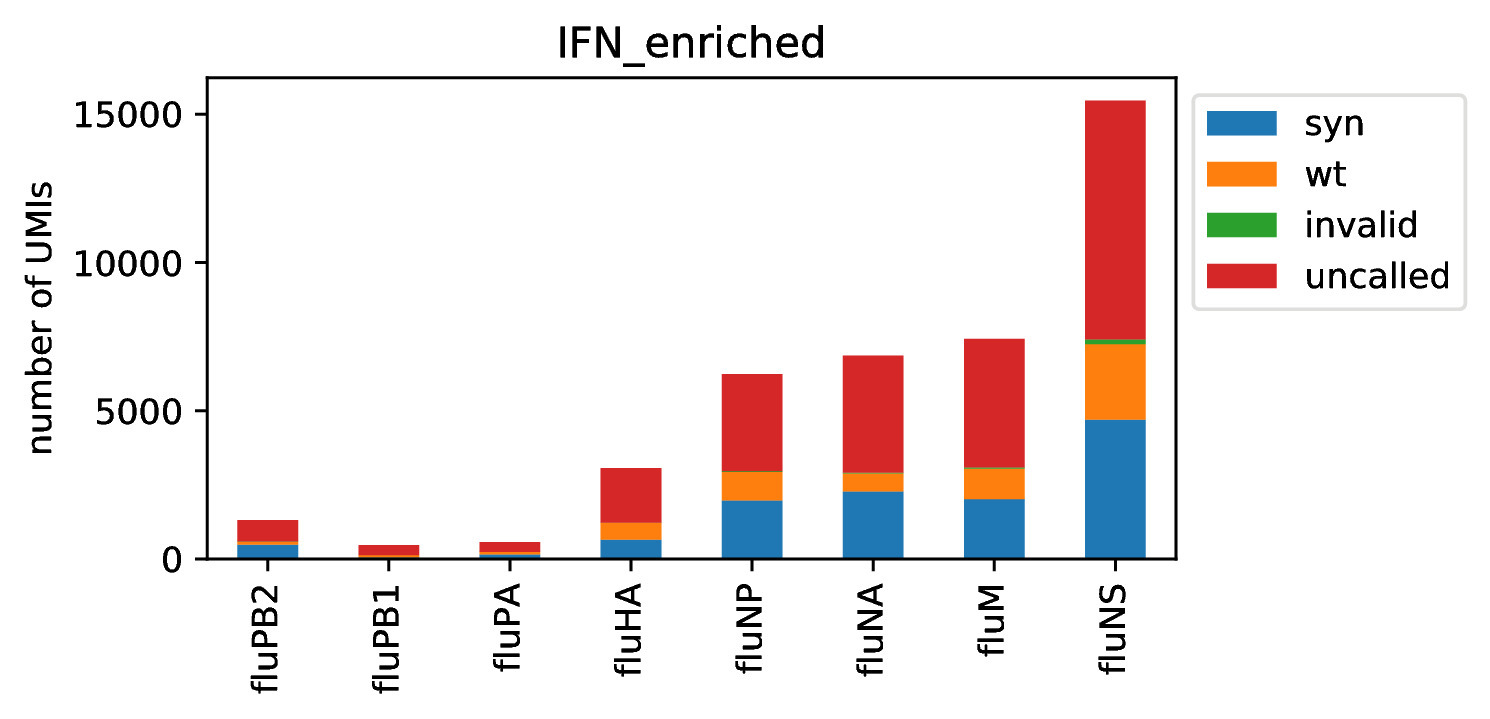


**********************
Plots on viral purity
For the humanplusflu cells:


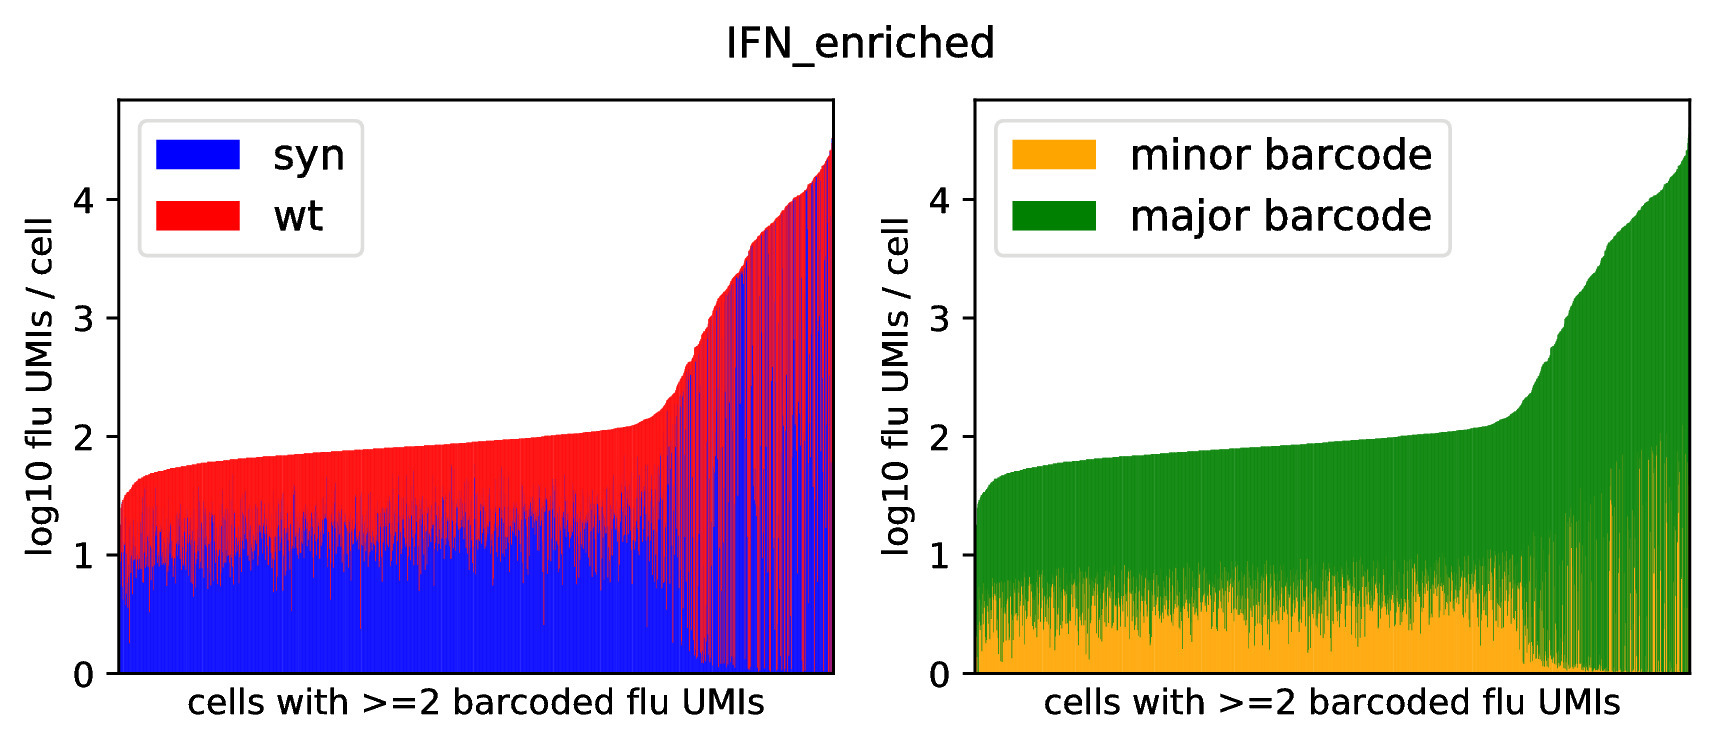

For the canine cells:


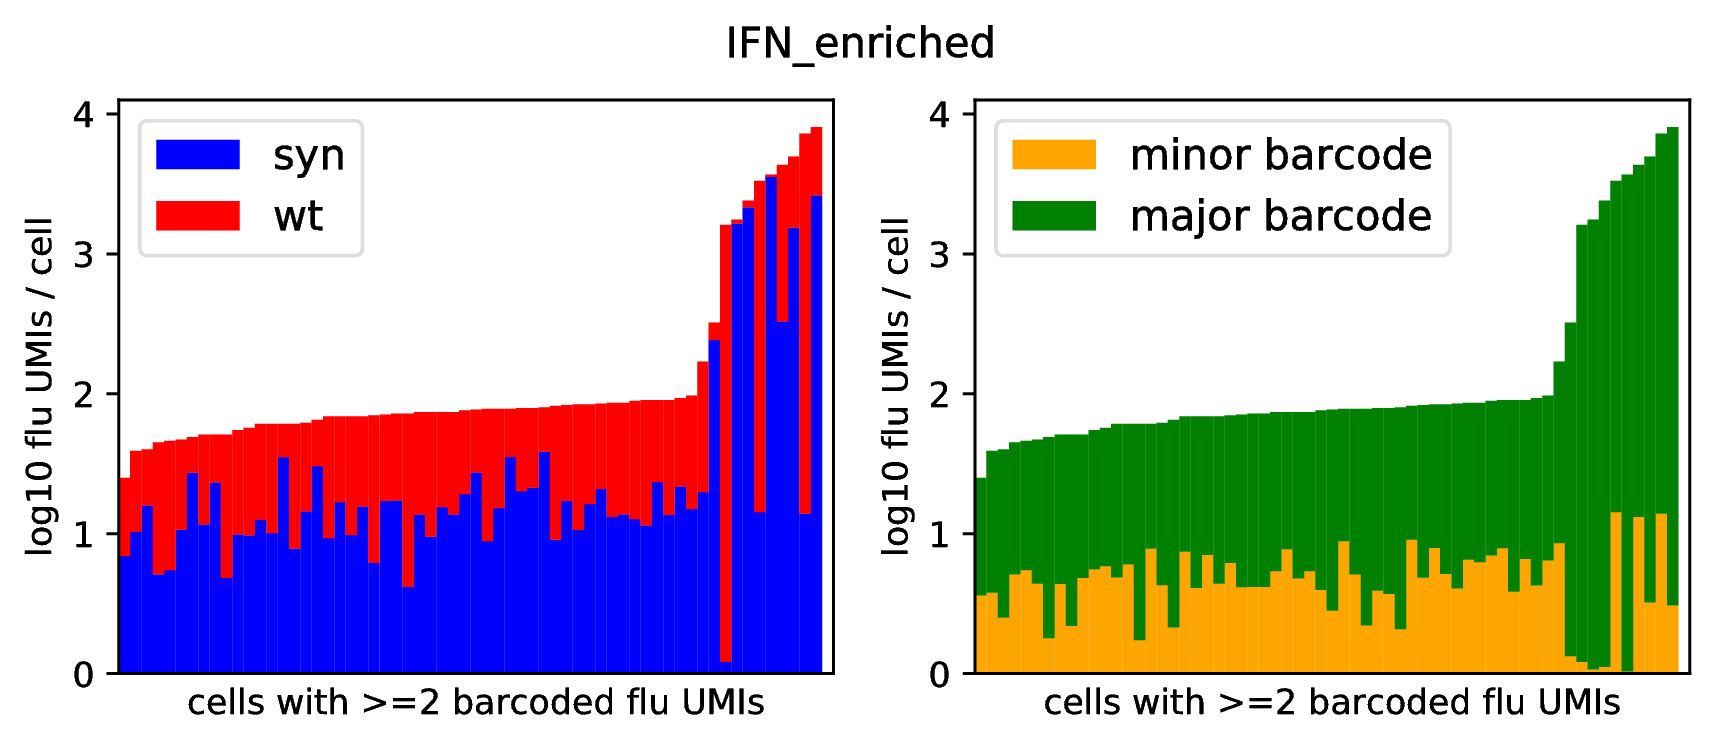

In [8]:
synbarcodeplots = os.path.join(plotsdir, './synbarcodes/')
if not os.path.isdir(synbarcodeplots):
    os.mkdir(synbarcodeplots)

for celltype in celltypes:
    for sample in samples:
        barcodes = os.path.join(counts[sample], '{0}_barcodes.tsv'.format(celltype))
        annotations = os.path.join(counts[sample], '{0}_cellannotations.tsv'.format(celltype))
        cellgene_d[celltype]['annotations'][sample] = annotations
        outprefix = os.path.join(synbarcodeplots, '{0}_{1}_'.format(sample, celltype))
        if os.path.isfile(annotations):
            print("Synonymous barcodes already annotated for {0} {1}".format(sample, celltype))
        else:
            print("Annotating synonymous barcodes for {0} {1}".format(sample, celltype))
            log = !python3 scripts/annotate_synbarcodes.py \
                    --flugenes {flu_genes} \
                    --synflugenes {flu_doublesyn_genes} \
                    --samplename {sample} \
                    --outprefix {outprefix} \
                    --cellbarcodes {barcodes} \
                    --bamfiles {bamfiles[sample]} \
                    && mv {outprefix}cellannotations.tsv {annotations}
        assert os.path.isfile(annotations), "Can't find {0}".format(annotations)

for plot in ['umistats', 'purity']:
    print("\n**********************\nPlots on viral {0}".format(plot))
    for celltype in celltypes:
        print("For the {0} cells:".format(celltype))
        outplot = os.path.join(plotsdir, 'synbarcodes_{0}.jpg'.format(plot))
        pymodules.utils.tilePlots([os.path.join(synbarcodeplots, '{0}_{1}_{2}.pdf'.format(
                sample, celltype, plot)) for sample in samples], outplot, ncols=3)
        display(Image(outplot))

From these plots we see several things:

  1. We are able to call the synonymous barcodes in about half of the influenza UMIs from the 10X whole-transcriptome sequencing. This is about as expected -- sometimes these barcodes won't be overlapped by the Illumina read, and so won't be callable. When we can call the barcodes, they are usually "valid" (e.g., they either have both or neither synonymous mutation). 
  
  2. The number of influenza UMIs is about as expected. The relative number of viral UMIs per segment is about as expected in the _humanplusflu_ cells. The three polymerase genes are lowest, and other genes are higher. The leakage to canine cells appears to occur most for NS for an unclear reason...
  
  3. In all populations, we find a mix of the wildtype and synonymous barcoded viruses. In cells with low numbers of reads, these are about equal in frequency indicating that we are just seeing leakage. It appears that leakage is the main source of viral mRNAs for cells with <100 reads. Beyond that, cells are often fairly pure indicating infection is the main source. As expected, the canine cells mostly appear to have RNA from leakage, but there are a few with lots of viral mRNA. There are probably doublets with infected human cells, but this is something we will look into in more detail in the Monocle analysis.

## Build merged cell-gene matrix suitable for loading into Monocle
We merge all of the samples into a single cell-gene matrix file, and also make merged genes and cell annotation files giving the rows and columns.
These cell-gene matrices and their annotations are appropriate for analysis with `Monocle`.

We build a different merged matrix for each celltype.

Also, in the genes file, we replace the prefix (e.g., `humanplusflu_`) from the genes. 
We don't need to annotate the genes with celltype since we don't merge the matrices across celltypes.

In [9]:
for celltype in celltypes:
    print("Building merged cell-gene matrix for {0}".format(celltype))
    mergedcounts = dict([(os.path.splitext(ftype)[0], os.path.join(countsdir, 
            'merged_{0}_{1}'.format(celltype, ftype))) 
            for ftype in ['genes.tsv', 'cells.tsv', 'matrix.mtx']])
    if all(map(os.path.isfile, mergedcounts.values())):
        print("The merged files already exist:\n\t{0}\n".format(
                '\n\t'.join(mergedcounts.values())))
    else:
        pymodules.utils.mergeCellGeneMatrices(
                mergedcounts['genes'],
                mergedcounts['cells'],
                mergedcounts['matrix'],
                samples,
                cellgene_d[celltype]['barcodes'],
                cellgene_d[celltype]['annotations'],
                cellgene_d[celltype]['genes'],
                cellgene_d[celltype]['matrix'],
                removeprefix=celltype
                )
        assert all(map(os.path.isfile, mergedcounts.values()))
        print("Created merged files:\n\t{0}\n".format(
                '\n\t'.join(mergedcounts.values())))

Building merged cell-gene matrix for humanplusflu
Created merged files:
	./results/./cellgenecounts/merged_humanplusflu_genes.tsv
	./results/./cellgenecounts/merged_humanplusflu_cells.tsv
	./results/./cellgenecounts/merged_humanplusflu_matrix.mtx

Building merged cell-gene matrix for canine
Created merged files:
	./results/./cellgenecounts/merged_canine_genes.tsv
	./results/./cellgenecounts/merged_canine_cells.tsv
	./results/./cellgenecounts/merged_canine_matrix.mtx

